In [1]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

## Bipartite network generation

### Data preparation

In [2]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [3]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [4]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

# DESCRIZIONE

In [5]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,269,53,3,123,116,0
Asia,34,19159,37,736,2464,6
Australia,0,55,605,62,210,1
Europe,20,745,82,23014,3904,35
North America,47,4081,331,6584,83604,57
South America,0,14,4,99,203,516


In [6]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=0)
cb_a

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,0.727027,0.143243,0.008108,0.332432,0.313514,0.000000
Asia,0.001410,0.794748,0.001535,0.030531,0.102211,0.000249
Australia,0.000000,0.051789,0.569680,0.058380,0.197740,0.000942
Europe,0.000653,0.024332,0.002678,0.751649,0.127507,0.001143
North America,0.000519,0.045093,0.003657,0.072751,0.923791,0.000630
South America,0.000000,0.022764,0.006504,0.160976,0.330081,0.839024


<AxesSubplot:ylabel='Density'>

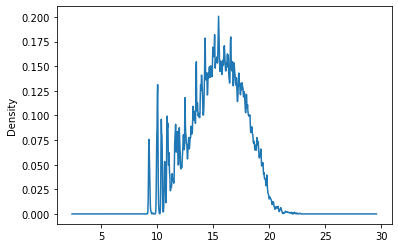

In [7]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

<AxesSubplot:ylabel='Density'>

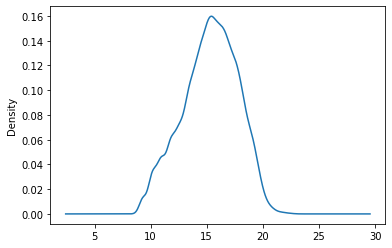

In [8]:
np.log(es3['size_real']).plot.kde()

In [10]:
es3.sort_values("size_real",ascending=False)[0:300]

In [11]:
cb[cb['target_name']=='zumutor']

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
4161,zumutor,Other Investors,NaN,NaN,Chiratae Ventures,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Other Investors,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Chiratae Ventures,chiratae.com,"Chiratae Ventures, formerly IDG Ventures India...",India,Venture Capital,44.0,19.0,256,3.0,"T. Meenakshisundaram (CFO),Manik Arora (Managi...",51.0,"Pharma Startups, Fitness Tech and Untitled…",1572.0,NaN,NaN,Asia,Bengaluru,2006.0,"7B, 7th Floor, Sobha Pearl 1, Commissariat Road…",NaN,NaN,NaN,NaN,NaT,NaT
151846,zumutor,Series A,4.0,11/27/2019,Accel,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Accel,accel.com,Accel is a venture capital firm that invests i...,United States,Venture Capital,115.0,58.0,"2,061",33.0,NaN,176.0,"Identity Management, Direct-To-Consumer Brands...",203.0,Investment Firms & Funds,California,North America,Palo Alto,1983.0,500 University Avenue,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019
151847,zumutor,Series A,4.0,11/27/2019,Bharat Fund,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Bharat Fund,bharat.fund,Bharat Fund is an early stage venture fund wit...,India,Venture Capital,1.0,1.0,10,0.0,NaN,4.0,NaN,100506.0,NaN,NaN,Asia,Ahmedabad,NaN,Centre for Innovation Incubation and Entrepren...,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019


In [12]:
cb

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
0,Shionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
1,Astellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
2,Sumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
4,Takeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187799,Beijing Shouyi,Acquired,NaN,08/17/2021,Healgen,shouyi-biochem.com…,"Beijing Shouyi is a biomedical enterprise, whi...",Medical Devices & Equipment,China,NaN,Acquired,669346,1998.0,Acquisition,Asia,Beijing,Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,NaN,2021-08,2021
187800,Centaur Labs,Series A,15.89,08/17/2021,Undisclosed Investors,centaurlabs.com,Centaur Labs enables customers to build AI alg...,Internet Software & Services,United States,"Digital Health, Artificial Intelligence ( AI )...",Alive / Active,377820,2017.0,Series A,North America,Massachusetts,Boston,"883 Boylston St, Suite 200…","Erik Duhaime (CEO),Zach Rausnitz (CTO)…",Aigorithm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,15890000.0,2021-08,2021
187801,Streamline Health Solutions,IPO,NaN,08/17/2021,Public,streamlinehealth.net,Streamline Health (NASDAQ: STRM) provides solu...,Healthcare Softwa

In [13]:
cb[cb['investors_name']=='Public'][-300:]

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
168627,Vaccibody,IPO,NaN,10/07/2020,Public,vaccibody.com,Vaccibody is a vaccine company dedicated to th...,Drug Development,Norway,"Pharma Startups, Cancer Therapeutics, Biopharm...",IPO / Went public,83448,2007.0,IPO,Europe,NaN,Oslo,Oslo Research Park Gaustadalleen 21…,Martin Bonde (CEO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,NaN,2020-10,2020
168697,Aziyo Biologics,IPO,133.06,10/08/2020,Public,aziyo.com,Aziyo Biologics (NASDAQ: AZYO) is a biotech co...,Biotechnology,United States,"Pharma Startups, Regenerative Medicine and Bio...",IPO / Went public,287569,2015.0,IPO,North America,Maryland,Silver Spring,12510 Prosperity Drive Suite 370…,Ronald Lloyd (CEO),Pinnacle Transplant Technologies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,1.399760e+08,2020-10,2020
168742,Shattuck Labs,IPO,150.00,10/09/2020,Public,shattucklabs.com,Shattuck Labs (NASDAQ: STTK) is a biotechnolog...,Drug Development,United States,"Pharma Startups, Cancer Therapeutics, Regenera...",IPO / Went public,260319,2016.0,IPO,North America,Texas,Austin,1018 West 11th Street Suite 100…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,1.577965e+08,2020-10,2020
168743,Spruce Biosciences,IPO,75.00,10/09/2020,Public,sprucebiosciences.com,Spruce Biosciences (NASDAQ: SPRB) is a clinica...,Biotechnology,United States,Rare Diseases and Biopharmaceuticals…,IPO / Went public,302492,2014.0,IPO,North America,California,San Francisco,2001 Junipero Serra Blvd. Suite 640…,"Alexis Howerton Ph.D. (Founder),Richard King (...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,7.889827e+07,2020-10,2020
168761,Everest Medicines,IPO,451.00,10/09/2020,Public,everestmedicines.com,Everest Medicines (01952.HK) is dedicated to d...,Drug Development,United States,Pharma Startups and Biopharmaceuticals…,IPO / Went public,331239,2017.0,IPO,North America,New York,New York,450 Lexington Ave Suite 39B…,Sean Cao (CEO),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,4.744416e+08,2020-10,2020
168762,Kronos Bio,IPO,250.00,10/09/2020,Public,kronosbio.com,Kronos Bio is dedicated to the research and de...,Biotechnology,United States,"Pharma Startups, Biopharmaceuticals and Cancer…",IPO / Went public,326897,2017.0,IPO,North America,California,San Mateo,1300 So. El Camino Real Suite 300…,"Angela Koehler (Founder),Norbert Bischofberger...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,2.629942e+08,2020-10,2020
168764,CSAM Health,IPO,NaN,10/09/2020,Public,csamhealth.com,CSAM is a privately-owned eHealth company base...,Healthcare Software,Norway,Digital Health and Cancer,IPO / Went public,184102,NaN,IPO,Europe,NaN,Oslo,Lysaker Torg 45b,"Sverre Flatby (CEO),Anne Quirk (CEO),Marcelino...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10,2020-10,260.462,NaN,2020-10,2020
168991,Codiak Biosciences,IPO,82.50,10/14/2020,Public,codiakbio.com,Codiak Biosciences is developing multiple plat...,Biotechnology,United States,"Pharma Startups, Regenerative Medicine and Bio...",IPO / Went public,243151,2015.0,IPO,North America,Massachusetts,Cambri

In [14]:
#ordinare gli investitori

inv_list = list(cb['investors_name'].values)
inv_counter = {}
for inv in inv_list:
    if inv in inv_counter:
        inv_counter[inv] += 1
    else:
        inv_counter[inv] = 1

popular_invs = sorted(inv_counter, key = inv_counter.get, reverse = True)
 
top = popular_invs[:20]

In [15]:
for i in popular_invs:
    if pd.isna(i):
        print(i)

nan


In [16]:
inv_counter['Dead']

353

# GRAPHS

In [17]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

,node,index,bipartite,id
0,Shionogi & Co.,262824.0,1,0
1,Astellas Pharma,243168.0,1,1
2,Sumitomo Dainippon Pharma,447180.0,1,2
3,Konica Minolta,57191.0,1,3
4,Takeda Pharmaceutical,373007.0,1,4
...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,0,83254
83255,Edvantage Group,190377.0,0,83255
83256,Healgen,NaN,0,83256


In [18]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [19]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [20]:
##ripeto quanto fatto prima (semplificato prima per risparmiare tempo) ma aggiungo roba
nodes_org = cb_new[['target_name', 'target_ID', 'target_country', 'target_continent',
               'industry','target_founded','target_status']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb_new[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type',
                   'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", "target_founded":"foundation"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry", "investor_id":'index',
                                     "investor_founded":"foundation"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes.columns



Index(['node', 'index', 'country', 'continent', 'industry', 'foundation',
       'target_status', 'bipartite', 'id'],
      dtype='object')

In [21]:
nodes

,node,index,country,continent,industry,foundation,target_status,bipartite,id
0,Shionogi & Co.,262824.0,Japan,Asia,Pharmaceuticals / Drugs,1878.0,IPO / Went public,1,0
1,Astellas Pharma,243168.0,Japan,Asia,Pharmaceuticals / Drugs,1923.0,IPO / Went public,1,1
2,Sumitomo Dainippon Pharma,447180.0,Japan,Asia,Pharmaceuticals / Drugs,1897.0,IPO / Went public,1,2
3,Konica Minolta,57191.0,Japan,Asia,Medical Devices & Equipment,1936.0,IPO / Went public,1,3
4,Takeda Pharmaceutical,373007.0,Japan,Asia,Pharmaceuticals / Drugs,1781.0,IPO / Went public,1,4
...,...,...,...,...,...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,China,Asia,Venture Capital,2016.0,NaN,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,China,Asia,Other,NaN,NaN,0,83254
83255,Edvantage Group,190377.0,China,Asia,Corporation,2015.0,NaN,0,83255
83256,Healgen,NaN,NaN,NaN,NaN,NaN,NaN,0,83256


In [22]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], round_simp =cb_new.loc[i,'round_simp'])

In [ ]:
##nodi brutti
#'Undisclosed Investors',
# 'Public',
#'Undisclosed Angel Investors',
#'Undisclosed Venture Investors',
#Dead


In [23]:
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)

In [ ]:
'Grant - XIII'

In [24]:
biz = [(x,y) for x,y,d in B.edges(data=True) if (d['round_simp']=='Portfolio Merger')]
biz

[(53555, 18400),
 (53882, 13658),
 (54420, 11461),
 (54420, 12507),
 (58370, 7975),
 (59311, 19853),
 (59311, 19910),
 (60228, 13572),
 (62332, 19486),
 (62332, 18609)]

In [ ]:
##degree sorting
sorted(B.degree, key=lambda x: x[1], reverse=True)

In [25]:
B.nodes[1119]

{'name': 'Bioenvision',
 'country': 'United States',
 'industry': 'Biotechnology',
 'foundation': 1996.0,
 'bipartite': 1,
 'target_status': 'Acquired'}

In [26]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

# NEW GRAPHS

# FOLLOWERS

In [27]:
#DA SISTEMARE

G_bidder_follow=nx.MultiDiGraph()
for org in Pallottola.Organisation.unique():
    ord_list = list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).id_y)
    time_list= list(Pallottola[Pallottola.Organisation==org].sort_values(by=['Date']).Date.dt.year)
    for idx in range(len(ord_list)):
        if ord_list[idx]!= np.nan:
            for seq in range(idx, len(ord_list)):
                if ord_list[seq]!=np.nan:
                    G_bidder_follow.add_edge(ord_list[idx], ord_list[seq], year=time_list[seq])

NameError: name 'Pallottola' is not defined

# BIDBID

In [28]:
id_round = cb_new[['target_ID','round_simp']]
id_round = id_round.drop_duplicates()
id_round.index = range(len(id_round))
id_round['id_round'] = id_round.index
id_round

id_year = cb_new[['target_ID','date_y']]
id_year = id_year.drop_duplicates()
id_year.index = range(len(id_year))
id_year['id_year'] = id_year.index
id_year

,target_ID,date_y,id_year
0,262824,1949,0
1,243168,1949,1
2,447180,1949,2
3,57191,1949,3
4,373007,1949,4
...,...,...,...
94835,669346,2021,94835
94836,377820,2021,94836
94837,439295,2021,94837
94838,439775,2021,94838


In [29]:
cb_new = pd.merge(cb_new, id_round,  how='left', left_on=['target_ID','round_simp'], right_on = ['target_ID','round_simp'])


In [30]:
cb_new = pd.merge(cb_new, id_year,  how='left', left_on=['target_ID','date_y'], right_on = ['target_ID','date_y'])

In [31]:
nodes_inv = nodes[nodes['bipartite']==0]

In [32]:
nodes_inv

,node,index,country,continent,industry,foundation,target_status,bipartite,id
50462,Public,NaN,NaN,NaN,NaN,NaN,NaN,0,50462
50463,Greylock Partners,721.0,United States,North America,Venture Capital,NaN,NaN,0,50463
50464,Undisclosed Angel Investors,NaN,NaN,NaN,NaN,NaN,NaN,0,50464
50465,J.H. Whitney,7440.0,United States,North America,Private Equity,1946.0,NaN,0,50465
50466,Takeda Ventures,22591.0,United States,North America,Corporate Venture,NaN,NaN,0,50466
...,...,...,...,...,...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,China,Asia,Venture Capital,2016.0,NaN,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,China,Asia,Other,NaN,NaN,0,83254
83255,Edvantage Group,190377.0,China,Asia,Corporation,2015.0,NaN,0,83255
83256,Healgen,NaN,NaN,NaN,NaN,NaN,NaN,0,83256


In [33]:
##bidbid in stesso anno
links = []
subcb = cb_new[['id_year','date_y','id_y']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_y'])]
for i in tqdm(subcb['id_year'].unique()):
    subcb2 = subcb[subcb['id_year']==i]
    for couple in itertools.combinations(np.unique(subcb2['id_y'].values),2):
        links.append((couple + ({'date': subcb2['date_y'].values[0].year},)))


  0%|          | 0/88171 [00:00<?, ?it/s]

In [34]:
bidbid=nx.MultiGraph()
bidbid.add_nodes_from(nodes[nodes.bipartite==0].id)
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.node, index=nodes_inv.id).to_dict(), 'name')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.country, index=nodes_inv.id).to_dict(), 'country')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.continent, index=nodes_inv.id).to_dict(), 'continent')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.industry, index=nodes_inv.id).to_dict(), 'industry')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.foundation, index=nodes_inv.id).to_dict(), 'foundation')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.bipartite, index=nodes_inv.id).to_dict(), 'bipartite')
bidbid.add_edges_from(links) 
remove = [node for node,degree in dict(bidbid.degree()).items() if degree == 0]
bidbid.remove_nodes_from(remove)
bidbid.remove_nodes_from(brutti)
nx.readwrite.write_gpickle(bidbid,'bidbid_cb.gpickle')
nx.info(bidbid)

'Name: \nType: MultiGraph\nNumber of nodes: 21902\nNumber of edges: 250433\nAverage degree:  22.8685'

In [35]:
nodes_inv.country

50462              NaN
50463    United States
50464              NaN
50465    United States
50466    United States
             ...      
83253            China
83254            China
83255            China
83256              NaN
83257    United States
Name: country, Length: 32796, dtype: object

In [36]:
bidbid.nodes[51253]

{'name': 'OrbiMed Advisors',
 'country': 'United States',
 'continent': 'North America',
 'industry': 'Venture Capital',
 'foundation': 1989.0,
 'bipartite': 0}

In [44]:
# sorted(bidbid.degree, key=lambda x: x[1], reverse=True)

In [39]:
##bidbid in stesso round
links = []
for i in cb_new['id_round'].unique():
    for couple in itertools.combinations(np.unique(cb_new[cb_new['id_round']==i]['id_y'].values),2):
            links_f.append((couple + ({'m_raised': np.unique(Pallottola[Pallottola['idx']==i]['USDraised_cpi'])),
                             'date': min(pd.to_datetime(Pallottola[Pallottola['idx']==i]['Date'].values)),
                             'round': Pallottola[Pallottola['idx']==i]['Funding type'].values[0],
                             'investors': cb_new.unique())),
                 'type': 'invinv'},)))
bidbid=MultiGraph()
bidbid.add_nodes_from(nodes.id)
bidbid.add_edges_from(links_)
    

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (<ipython-input-39-5069199a033a>, line 5)

In [38]:
cb_new.head()

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y,investor_numbers,node_x,index_x,bipartite_x,id_x,node_y,index_y,bipartite_y,id_y,id_round,id_year
0,Shionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949,1,Shionogi & Co.,262824.0,1,0,Public,NaN,0,50462,0,0
1,Astellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949,1,Astellas Pharma,243168.0,1,1,Public,NaN,0,50462,1,1
2,Sumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949,1,Sumitomo Dainippon Pharma,447180.0,1,2,Public,NaN,0,50462,2,2
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949,1,Konica Minolta,57191.0,1,3,Public,NaN,0,50462,3,3
4,Takeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949,1,Takeda Pharmaceutical,373007.0,1,4,Public,NaN,0,50462,4,4


# WINDOW

In [ ]:
from itertools import islice

def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
finestra = window(list(range(2000,2022)),5)

In [ ]:
for periodo in finestra:
    locals()["B_"+str(periodo[-1])]=nx.MultiGraph([(u,v,d) for u,v,d in B.edges(data=True) if d['date'] in periodo])

# COMMUNITIES

In [ ]:
partition = community_louvain.best_partition(bidbid)

In [ ]:
partition

In [ ]:
pos = nx.spring_layout(B)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
len(partition)

In [ ]:
cb_new.groupby('round_simp').count()

In [ ]:
'Asset Sale' 'Convertible Note' 'Dead' 'Debt' 'Distressed & Special Situation' 'Leveraged Buyout' 'Line of Credit' 'Loan'
'Mezzanine' 'Merger' 'Revenue Finance' 'Project Finance'

# Descriptive statistics

In [43]:
nodes

,node,index,country,continent,industry,foundation,target_status,bipartite,id
0,Shionogi & Co.,262824.0,Japan,Asia,Pharmaceuticals / Drugs,1878.0,IPO / Went public,1,0
1,Astellas Pharma,243168.0,Japan,Asia,Pharmaceuticals / Drugs,1923.0,IPO / Went public,1,1
2,Sumitomo Dainippon Pharma,447180.0,Japan,Asia,Pharmaceuticals / Drugs,1897.0,IPO / Went public,1,2
3,Konica Minolta,57191.0,Japan,Asia,Medical Devices & Equipment,1936.0,IPO / Went public,1,3
4,Takeda Pharmaceutical,373007.0,Japan,Asia,Pharmaceuticals / Drugs,1781.0,IPO / Went public,1,4
...,...,...,...,...,...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,China,Asia,Venture Capital,2016.0,NaN,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,China,Asia,Other,NaN,NaN,0,83254
83255,Edvantage Group,190377.0,China,Asia,Corporation,2015.0,NaN,0,83255
83256,Healgen,NaN,NaN,NaN,NaN,NaN,NaN,0,83256


## Adding bidder specific covariates

In [ ]:
# locals()["bidbiddir"+str(periodo[-1])]

In [76]:
valori=2
valour=3
lista=[]
lista.append(valori)

In [77]:
lista

[2]

In [57]:
bidbid_multi=nx.readwrite.read_gpickle('bidbid_stage_cb.gpickle')

In [80]:
bidbid_stage_single=nx.readwrite.read_gpickle('bidbid_stage_single_cb.gpickle')

In [58]:
nx.info(bidbid_multi)

'Name: \nType: MultiGraph\nNumber of nodes: 17089\nNumber of edges: 221765\nAverage degree:  25.9541'

### 1. Connected components

In [45]:
nx.info(B)

'Name: org-bid\nType: MultiGraph\nNumber of nodes: 83253\nNumber of edges: 159161\nAverage degree:   3.8235'

In [46]:
dictionary={}
count=0
for component in nx.connected_components(B):
    dictionary[count]=(component,len(component))
    count+=1

In [48]:
for node in tqdm(range(len(nodes))):
    dictionary2={}
    for component in range(len(dictionary)):
        if node in dictionary[component][0]:
            dictionary2[component]=dictionary[component][1]
    try:
        nodes.iloc[node,8]=[dictionary2]
    except:
        nodes.iloc[node,8]=np.nan

  0%|          | 0/83258 [00:00<?, ?it/s]

In [50]:
nx.number_connected_components(B)

12785

### 2. Degree centrality

In [51]:
deg_centrality=nx.degree_centrality(B)

### 3. Constraint (structural holes)

Constraint means how tied you are/how controlloed you are (in percentage). Low percentage means that your neighbors don't talk with one another, and this leads you to have more freedom. <b> TOO SLOW </b>

In [60]:
# constraint=nx.constraint(bidbid_multi)

### 4. Voterank centrality

In [ ]:
votes=nx.voterank(B)
votes_bidders=nx.voterank(bidbid_multi)

### 5. Eigenvector centrality (bipartite)

In [63]:
# nx.eigenvector_centrality(bidbid_stage_single)

### 6. Eigenvector centrality (bid-bid) 

General eigenvector centrality of investors

In [ ]:
nx.eigenvector_centrality(B)

Eigenvector centrality of time windows (4 years time window)

In [ ]:
nx.eigenvector_centrality(B)

### 8. Pagerank centrality (bid-bid)

In [ ]:
nx.pagerank(B)

### 9. Closeness centrality

In [ ]:
nx.closeness_centrality(B)
nx.incremental_closeness_centrality(B)

### 10. Betweenness centrality

In [ ]:
nx.betweenness_centrality(B)

### 11. Load centrality

In [ ]:
nx.load_centrality(B)

### 12. Subgraph centrality

In [ ]:
nx.subgraph_centrality(G)

### 13. Dispersion

In [ ]:
nx.dispersion(B)

### 14. Percolation

In [ ]:
nx.percolation_centrality(B)

### 15. Assortativity - average neighboring degree

In [ ]:
neigh_degree=nx.average_neighbor_degree(B)

## Applying all the functions to the network

In [82]:
def apply_function_network(lista_storage,lista_nomi,funzione,directed=False):
    for year in tqdm(range(1997,2021)):
        string='bidbid_stage_single_'+str(year)+'.gpickle'
        network=nx.readwrite.read_gpickle(string)
        storage=str(funzione)+'_single_'+str(year)
        lista_storage.append(funzione(network))
        lista_nomi.append(storage)
    network=nx.readwrite.read_gpickle('bidbid_stage_single_cb.gpickle')
    lista_storage.append(funzione(network))
    lista_nomi.append(str(funzione)+'_single')
    return lista_storage,lista_nomi

In [94]:
# Array di funzioni da applicare - ciclo for su di esse
lista_funzioni=[nx.voterank, nx.eigenvector_centrality, nx.degree_centrality, nx.pagerank, nx.closeness_centrality, nx.incremental_closeness_centrality, nx.load_centrality, nx.subgraph_centrality, nx.dispersion, nx.percolation_centrality,nx.average_neighbor_degree,nx.constraint, nx.betweenness_centrality]
# Funzione prende df, se direzionato o meno
lista_funzioni_prova=[nx.eigenvector_centrality, nx.degree]
lista_storage=[]
lista_nomi=[]
for funzione in lista_funzioni:
    try:
        print('Trying'+str(funzione))
        lista_storage, lista_nomi=apply_function_network(lista_storage,lista_nomi,funzione)
    except:
        print(str(funzione)+' did not work')
        continue

Trying<function voterank at 0x7fc0292eeb80>


  0%|          | 0/24 [00:00<?, ?it/s]

<function voterank at 0x7fc0292eeb80> did not work
Trying<function eigenvector_centrality at 0x7fc0292e2700>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function degree_centrality at 0x7fc0292d8940>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function pagerank at 0x7fc029356dc0>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function closeness_centrality at 0x7fc0292cc310>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function incremental_closeness_centrality at 0x7fc0292cc550>


  0%|          | 0/24 [00:00<?, ?it/s]

<function incremental_closeness_centrality at 0x7fc0292cc550> did not work
Trying<function newman_betweenness_centrality at 0x7fc0292cc670>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function subgraph_centrality at 0x7fc0292ccd30>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function dispersion at 0x7fc0292e24c0>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function percolation_centrality at 0x7fc0292ee160>


  0%|          | 0/24 [00:00<?, ?it/s]

<function percolation_centrality at 0x7fc0292ee160> did not work
Trying<function average_neighbor_degree at 0x7fc038895af0>


  0%|          | 0/24 [00:00<?, ?it/s]

Trying<function constraint at 0x7fbff94c03a0>


  0%|          | 0/24 [00:00<?, ?it/s]

<function constraint at 0x7fbff94c03a0> did not work
Trying<function betweenness_centrality at 0x7fc0292c1f70>


  0%|          | 0/24 [00:00<?, ?it/s]

Adding the column names to the dataframe

In [147]:
import re

regex = r"(?<=function )(.*)(?= at)"
regex2= r"\>(.*)"

for test_str in lista_nomi:
    matches = re.finditer(regex, test_str, re.MULTILINE)
    matches2 = re.finditer(regex2, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):
        stringa1=match.group()
    for matchNum, match in enumerate(matches2, start=1):
        stringa2=match.group()
    stringa_totale=stringa1+stringa2[1:]
    nodes[stringa_totale]=np.nan
nodes

,node,index,country,continent,industry,foundation,target_status,bipartite,id,voterank_single_1997,voterank_single_1998,voterank_single_1999,voterank_single_2000,voterank_single_2001,voterank_single_2002,voterank_single_2003,voterank_single_2004,voterank_single_2005,voterank_single_2006,voterank_single_2007,voterank_single_2008,voterank_single_2009,voterank_single_2010,voterank_single_2011,voterank_single_2012,voterank_single_2013,voterank_single_2014,voterank_single_2015,voterank_single_2016,voterank_single_2017,voterank_single_2018,voterank_single_2019,voterank_single_2020,eigenvector_centrality_single_1997,eigenvector_centrality_single_1998,eigenvector_centrality_single_1999,eigenvector_centrality_single_2000,eigenvector_centrality_single_2001,eigenvector_centrality_single_2002,eigenvector_centrality_single_2003,eigenvector_centrality_single_2004,eigenvector_centrality_single_2005,eigenvector_centrality_single_2006,eigenvector_centrality_single_2007,eigenvector_centrality_single_2008,eigenvector_centrality_single_2009,eigenvector_centrality_single_2010,eigenvector_centrality_single_2011,eigenvector_centrality_single_2012,eigenvector_centrality_single_2013,eigenvector_centrality_single_2014,eigenvector_centrality_single_2015,eigenvector_centrality_single_2016,eigenvector_centrality_single_2017,eigenvector_centrality_single_2018,eigenvector_centrality_single_2019,eigenvector_centrality_single_2020,eigenvector_centrality_single,degree_centrality_single_1997,degree_centrality_single_1998,degree_centrality_single_1999,degree_centrality_single_2000,degree_centrality_single_2001,degree_centrality_single_2002,degree_centrality_single_2003,degree_centrality_single_2004,degree_centrality_single_2005,degree_centrality_single_2006,degree_centrality_single_2007,degree_centrality_single_2008,degree_centrality_single_2009,degree_centrality_single_2010,degree_centrality_single_2011,degree_centrality_single_2012,degree_centrality_single_2013,degree_centrality_single_2014,degree_centrality_single_2015,degree_centrality_single_2016,degree_centrality_single_2017,degree_centrality_single_2018,degree_centrality_single_2019,degree_centrality_single_2020,degree_centrality_single,pagerank_single_1997,pagerank_single_1998,pagerank_single_1999,pagerank_single_2000,pagerank_single_2001,pagerank_single_2002,pagerank_single_2003,pagerank_single_2004,pagerank_single_2005,pagerank_single_2006,pagerank_single_2007,pagerank_single_2008,pagerank_single_2009,pagerank_single_2010,pagerank_single_2011,pagerank_single_2012,pagerank_single_2013,pagerank_single_2014,pagerank_single_2015,pagerank_single_2016,pagerank_single_2017,pagerank_single_2018,pagerank_single_2019,pagerank_single_2020,pagerank_single,closeness_centrality_single_1997,closeness_centrality_single_1998,closeness_centrality_single_1999,closeness_centrality_single_2000,closeness_centrality_single_2001,closeness_centrality_single_2002,closeness_centrality_single_2003,closeness_centrality_single_2004,closeness_centrality_single_2005,closeness_centrality_single_2006,closeness_centrality_single_2007,closeness_centrality_single_2008,closeness_centrality_single_2009,closeness_centrality_single_2010,closeness_centrality_single_2011,closeness_centrality_single_2012,closeness_centrality_single_2013,closeness_centrality_single_2014,closeness_centrality_single_2015,closeness_centrality_single_2016,closeness_centrality_single_2017,closeness_centrality_single_2018,closeness_centrality_single_2019,closeness_centrality_single_2020,closeness_centrality_single,newman_betweenness_centrality_single_1997,newman_betweenness_centrality_single_1998,newman_betweenness_centrality_single_1999,newman_betweenness_centrality_single_2000,newman_betweenness_centrality_single_2001,newman_betweenness_centrality_single_2002,newman_betweenness_centrality_single_2003,newman_betweenness_centrality_single_2004,newman_betweenness_centrality_single_2005,newman_betweenness_centrality_single_2006,newman_betweenness_centrality_single_2007,ne

In [159]:
# lista_storage[0][0]

In [209]:
#Inserisco voterank
for voterank_year in tqdm(range(24)):
    for rank in range(len(lista_storage[voterank_year][0])):
        nodes.iloc[lista_storage[voterank_year][0][rank],9+voterank_year]=rank
#Inserisco le altre covariate fino a dispersion
for covariate in tqdm(range(24,174)):
    for node in lista_storage[covariate][0]:
        nodes.iloc[node,9+covariate]=lista_storage[covariate][0][node]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [234]:
nodes.iloc[50465,9+174]=[lista_storage[174][0][50465]]

In [235]:
#Inserisco le altre covariate, compresa dispersion
for covariate in tqdm(range(174,259)):
    for node in lista_storage[covariate][0]:
        try:
            nodes.iloc[node,9+covariate]=lista_storage[covariate][0][node]
        except:
            nodes.iloc[node,9+covariate]=[lista_storage[covariate][0][node]]

  0%|          | 0/85 [00:00<?, ?it/s]

In [236]:
nodes.to_csv('CB_with_covariates.csv')